In [2]:
# ── セル 1: ライブラリのインストール ───────────────────────────────
!pip install -q pdfplumber pandas openpyxl
!pip install -q japanize-matplotlib

In [3]:
# ── セル 2: インポート ───────────────────────────────────────────
import pdfplumber, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import japanize_matplotlib

In [4]:
# ── セル 3: PDF からテーブル抽出 ────────────────────────────────
pdf_path = Path("商品発注表.pdf")
assert pdf_path.exists(), f"PDF が見つかりません: {pdf_path.resolve()}"
 
tables = []
with pdfplumber.open(pdf_path) as pdf:
    for page in pdf.pages:
        tables.extend(page.extract_tables())
 
# ヘッダーに「商品コード」があるテーブルを採用
df = None
for tbl in tables:
    if tbl and any("商品コード" in (cell or "") for cell in tbl[0]):
        df = pd.DataFrame(tbl[1:], columns=tbl[0])
        break
if df is None:
    raise ValueError("対象となるテーブルが見つかりません。")
 
print("抽出列:", df.columns.tolist())  # 列名を確認

Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats
Could get FontBBox from font descriptor because None cannot be parsed as 4 floats


抽出列: ['No.', '商品コード', '商品名', '仕様・規格', '単位', '数量', '単価(円)', '金額(円)', '備考']


In [5]:
# ── セル 4: 列名を標準化し、必要列を自動検出 ─────────────────────
# 全角記号や空白を取り除く
df = df.rename(
    columns=lambda c: (
        c.strip()
         .replace("（", "(")
         .replace("）", ")")
         .replace(" ", "")
         .replace("\t", "")
    )
)
 
# キーワードで列名を見つける
qty_col   = next((c for c in df.columns if "数量" in c),  None)
price_col = next((c for c in df.columns if "単価" in c),  None)
amt_col   = next((c for c in df.columns if "金額" in c),  None)
 
print("数量列:", qty_col, "| 単価列:", price_col, "| 金額列:", amt_col)
if None in (qty_col, price_col, amt_col):
    raise KeyError("数量・単価・金額に該当する列が見つかりません。")

数量列: 数量 | 単価列: 単価(円) | 金額列: 金額(円)


In [6]:
# ── セル 5: 数値列の整形 ───────────────────────────────
for col in (qty_col, price_col, amt_col):
    df[col] = (
        df[col]
          .astype(str)
          .str.replace(",", "", regex=False)
          .str.replace("円", "", regex=False)
          .str.strip()
          .astype(float)
    )
 
df[qty_col]   = df[qty_col].astype(int)
df[price_col] = df[price_col].astype(int)
df[amt_col]   = df[amt_col].astype(int)
 
display(df.head())  # プレビュー

,No.,商品コード,商品名,仕様・規格,単位,数量,単価(円),金額(円),備考
0,1,A001-001,コピー用紙 A4,白色 500枚/包,箱,50,2500,125000,10箱/ケース
1,2,B002-005,ボールペン 黒,0.7mm ノック式,本,200,120,24000,10本/箱
2,3,C003-012,クリアファイル A4,20ポケット 透明,冊,100,350,35000,
3,4,D004-025,プリンターインク,BK 大容量,個,30,3200,96000,純正品
4,5,E005-008,付箋紙セット,75×75mm 5色,セット,80,480,38400,100枚×5色


In [7]:
# ── セル 6: Excel へ書き出し ───────────────────────────────────
excel_path = Path("商品発注表.xlsx")
df.to_excel(excel_path, index=False, engine="openpyxl")
print(f"Excel ファイルを保存しました → {excel_path.resolve()}")

Excel ファイルを保存しました → C:\Users\User\商品発注表.xlsx


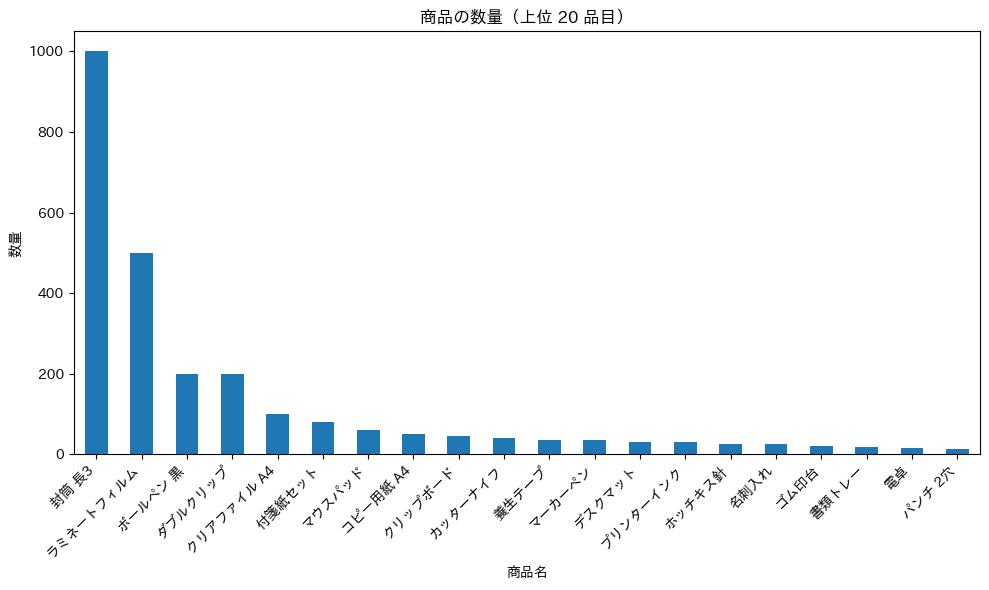

In [8]:
# ── セル 7: 数量を棒グラフで可視化 ────────────────────────────────
import matplotlib.pyplot as plt
 
# グラフに使うキー（商品名があれば優先、無ければ商品コード）
group_key = "商品名" if "商品名" in df.columns else "商品コード"
 
# 品目ごと数量を合計して多い順に並べ替え
qty_by_item = (
    df.groupby(group_key)[qty_col]
      .sum()
      .sort_values(ascending=False)
)
 
plt.figure(figsize=(10, 6))
qty_by_item.head(20).plot(kind="bar")          # 上位 20 品目を表示
plt.title("商品の数量（上位 20 品目）")
plt.ylabel("数量")
plt.xlabel(group_key)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("quantity_barplot.png", dpi=300)    # 画像ファイルとしても保存
plt.show()

In [10]:
print("▼ 集計レポート")
total_qty = df[qty_col].sum()
total_amt = df[amt_col].sum()
total_amt_tax = total_amt * 1.10

print(f"  総数量          : {total_qty:,}")
print(f"  総金額 (税抜)   : {total_amt:,}")
print(f"  総金額 (税込)   : {total_amt_tax:,.0f}")

print("\n▼ 数量 上位 5 品目")
display(qty_by_item.head(5).to_frame(name="数量"))

print("\n▼ 金額 上位 5 品目")
amt_by_item = (
    df.groupby(group_key)[amt_col]
      .sum()
      .sort_values(ascending=False)
)
display(amt_by_item.head(5).to_frame(name="金額 (円)"))


▼ 集計レポート
  総数量          : 2,521
  総金額 (税抜)   : 710,980
  総金額 (税込)   : 782,078

▼ 数量 上位 5 品目


,数量
商品名,
封筒 長3,1000
ラミネートフィルム,500
ボールペン 黒,200
ダブルクリップ,200
クリアファイル A4,100



▼ 金額 上位 5 品目


,金額 (円)
商品名,
コピー用紙 A4,125000
プリンターインク,96000
デスクマット,58500
書類トレー,43200
電卓,42000
